## Prompt Chain Pattern

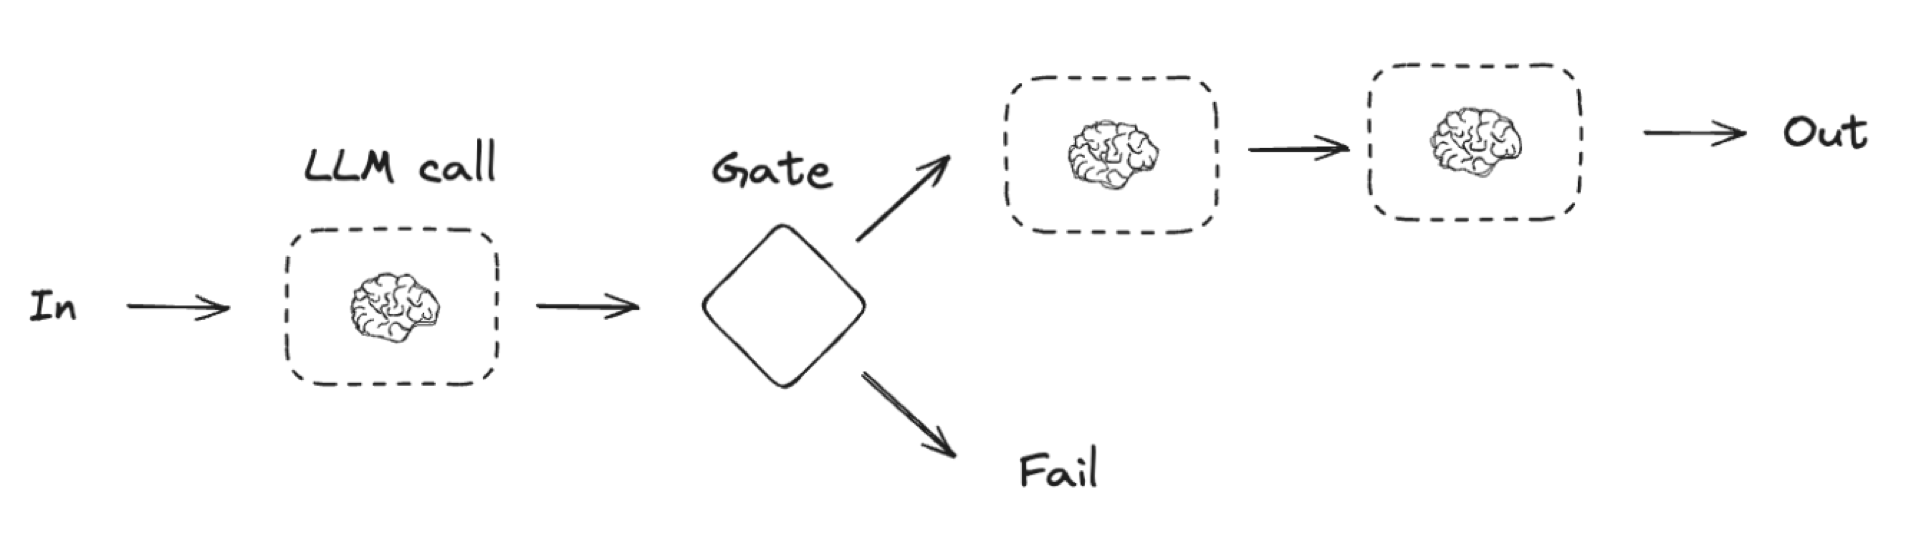

##### Load the environment variables

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()
tavily_api_key = os.getenv('TAVILY_API_KEY')
model_id = os.getenv('MODEL_ID')
aws_region = os.getenv('AWS_REGION')
bedrock_kb_id = os.getenv('BEDROCK_KB_ID')

##### Model

In [ ]:
## Model - Agent Brain
from langchain_aws import ChatBedrock
llm = ChatBedrock(model=model_id)

##### State - The schema of the State will be the input schema to all Nodes and Edges in the graph

In [ ]:
## Graph State
from typing import TypedDict

class State(TypedDict):
    query: str
    web_search: str
    kb_search: str
    final_blog: str

##### Tools [Tool 1 - Web Search Tool]

In [ ]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults

def search_web(state: State):
    print("SEARHING WEB")
    search_tool = TavilySearchResults(max_results=2)
    web_results = search_tool.invoke(state["query"])
    print(web_results)
    return {"web_search": web_results}

##### Tools [Tool 2 - Bedrock Knowledge Base]

In [ ]:
import boto3
def query_knowledge_base(state: State):
    """Query the knowledge base for information related to Agents and Agentic workflow
    
    Args:
        query: The query string to search for
    """
    bedrock_agent = boto3.client('bedrock-agent-runtime', region_name = aws_region)
    print("QUERYING KB")


    response = bedrock_agent.retrieve_and_generate(
        input={
            "text": state["query"]  # Your query text goes here
        },
        retrieveAndGenerateConfiguration={
            "type": "KNOWLEDGE_BASE",
            "knowledgeBaseConfiguration": {
                "knowledgeBaseId": bedrock_kb_id,
                "modelArn": model_id,
                "retrievalConfiguration": {
                    "vectorSearchConfiguration": {
                        "numberOfResults": 5
                    }
                }
            }
        }
    )

    print(kb_results)
    kb_results = response['output']['text']
    return {"kb_search" : kb_results}

##### Tools [Tool 3 - Blog writer tool]

In [ ]:
def blogger(state: State):
    print("WRITING BLOG")
    if 'web_search' in state:
        prompt = f""" Your job is to create a blog title and a one paragraph blog from this content: {state['web_search']}"""
    else:
        prompt = f""" Your job is to create a blog title and a one paragraph blog from this content: {state['kb_search']}"""

    print(prompt)
    final_answer = llm.invoke(prompt)           
    return {"final_blog": final_answer.content}    

##### Build the Graph

In [ ]:
from langgraph.graph import StateGraph, START, END

# Build workflow
chainer = StateGraph(State)

# Add nodes
chainer.add_node("search_kb", query_knowledge_base)
chainer.add_node("blog_writer", blogger)

# Add edges to connect nodes
chainer.add_edge(START, "search_kb")
chainer.add_edge("search_kb", "blog_writer")
chainer.add_edge("blog_writer", END)

##### Compile the graph

In [ ]:
agent = chainer.compile()

In [ ]:

from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

##### Run the agent

In [ ]:
state = agent.invoke({"query": "What is agentic memory"})
state['final_blog']


#### Conditional Edges

##### Define Conditional Node

In [ ]:
def conditional_node(state:State):
    condition = "I apologize"
    if condition in state['kb_search']:
        return "fail"
    else:
        return "pass"

##### Build the graph

In [ ]:
from langgraph.graph import StateGraph, START, END

# Build workflow
chainer = StateGraph(State)

# Add nodes
chainer.add_node("search_kb", query_knowledge_base)
chainer.add_node("search_web", search_web)
chainer.add_node("blog_writer", blogger)

# Add edges to connect nodes
chainer.add_edge(START, "search_kb")
chainer.add_conditional_edges("search_kb", conditional_node, {"pass": "blog_writer", "fail" : "search_web"})
chainer.add_edge("search_web", "blog_writer")
chainer.add_edge("blog_writer", END)

##### Compile the graph

In [ ]:
agent = chainer.compile()

from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

##### Run the Agent

In [ ]:
state = agent.invoke({"query": "who is usain bolt"})
state['final_blog']